In [1]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Select the Runtime > "Change runtime type" menu to enable a GPU accelerator, ')
  print('and then re-execute this cell.')
else:
  print(gpu_info)

Mon Jun 28 23:25:00 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 465.27       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   35C    P0    25W / 300W |      0MiB / 16160MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
pip install keras_hist_graph

In [3]:

import os 
import cv2
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt 
import tensorflow as tf
from collections import Counter
from keras.models import Sequential
from keras.layers import Dense,Dropout,Activation,Flatten, Input, ZeroPadding2D,InputLayer
from keras.layers.normalization import BatchNormalization
from keras.layers import Conv2D, MaxPooling2D, AveragePooling2D
from keras.regularizers import l2
from keras.models import Model
from keras.wrappers.scikit_learn import KerasClassifier
from keras.optimizers import RMSprop, SGD
from keras.callbacks import History, ModelCheckpoint, EarlyStopping,ReduceLROnPlateau
from keras.optimizers import RMSprop
from keras.constraints import unit_norm
from keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from keras_hist_graph import plot_history
%matplotlib inline

In [4]:
pip install livelossplot

In [5]:
!pip install ipython-autotime
%load_ext autotime

time: 130 µs (started: 2021-06-28 23:25:15 +00:00)


In [6]:

from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from keras.applications.vgg16 import decode_predictions, preprocess_input, VGG16
from keras.applications.resnet_v2 import ResNet50V2
from keras.applications.inception_v3 import InceptionV3
from keras.applications.inception_resnet_v2 import InceptionResNetV2
from livelossplot.inputs.keras import PlotLossesCallback
from tensorflow.keras.models import load_model

time: 15.7 ms (started: 2021-06-28 23:25:16 +00:00)


In [7]:
#set the training path
training_path='/content/drive/MyDrive/Formation_Machine_Learning/P6/data/resized_images/training_data'
#set the validation path
validation_path='/content/drive/MyDrive/Formation_Machine_Learning/P6/data/resized_images/validation_data'
#set the test path
test_path='/content/drive/MyDrive/Formation_Machine_Learning/P6/data/resized_images/test_data'

time: 1.43 ms (started: 2021-06-28 23:25:20 +00:00)


## **5 breeds**

## Setting the data

In [ ]:
breeds=['chow','collie','cairn','dhole','dingo']

In [ ]:
rotation_gen=ImageDataGenerator(rotation_range=90,fill_mode='nearest',rescale=1/255)
rotation_train=rotation_gen.flow_from_directory(training_path, target_size=(224, 224),classes=breeds,
                              class_mode='categorical', batch_size=20)

Found 553 images belonging to 5 classes.


In [ ]:
validation_gen=ImageDataGenerator(rescale=1/255)
aug_validation=validation_gen.flow_from_directory(validation_path,target_size=(224, 224),classes=breeds,
                              class_mode='categorical', batch_size=20, shuffle=False)

Found 172 images belonging to 5 classes.


In [ ]:
test_gen=ImageDataGenerator(rescale=1/255)
aug_test=validation_gen.flow_from_directory(test_path,target_size=(224, 224),classes=breeds,
                              class_mode='categorical', batch_size=20, shuffle=False)

Found 127 images belonging to 5 classes.


In [ ]:
classes=len(breeds)

In [ ]:
conv.summary()

In [8]:
def create_model(n_classes,tuning_layers):

  #Import the pre-trained VGG model without the fully connected layers on top
  conv_inception=InceptionResNetV2(weights='imagenet', 
                  include_top = False,
                  input_shape = (224,224, 3))

  #setting the fine-tuning loop
  if tuning_layers==0:
    conv_inception.trainable=False
  else:
    for layer in conv_inception.layers[:-tuning_layers]:
      layer.trainable=False

  #bootstrapping a new top_model into the pre-trained model

  model=Sequential()
  model.add(conv_inception)
  model.add(Flatten())
  model.add(Dense(512, activation='relu',input_shape=(None,38400)))
  model.add(Dropout(0.3))
  model.add(Dense(n_classes,activation='softmax'))

  model.compile(optimizer='adam',
                  loss='categorical_crossentropy',
                  metrics=['acc'])
  
  return model

time: 9.57 ms (started: 2021-06-28 23:25:28 +00:00)


### Without using fine-tuning

In [ ]:
inceptionV4_0=create_model(n_classes=classes, tuning_layers=0)

In [ ]:
inceptionV4_0.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_resnet_v2 (Functio (None, 5, 5, 1536)        54336736  
_________________________________________________________________
flatten_1 (Flatten)          (None, 38400)             0         
_________________________________________________________________
dense_2 (Dense)              (None, 512)               19661312  
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 5)                 2565      
Total params: 74,000,613
Trainable params: 19,663,877
Non-trainable params: 54,336,736
_________________________________________________________________


In [ ]:
plot_tun0=PlotLossesCallback()

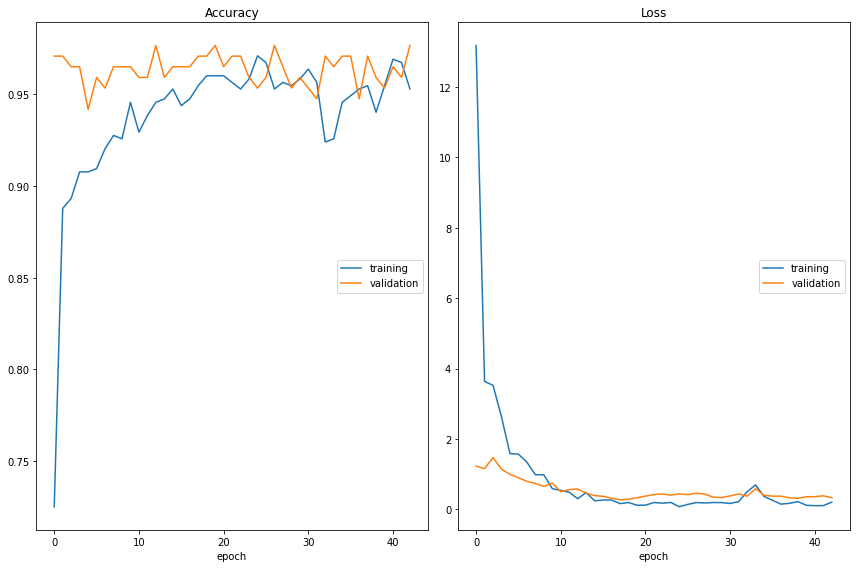

Accuracy
	training         	 (min:    0.725, max:    0.971, cur:    0.953)
	validation       	 (min:    0.942, max:    0.977, cur:    0.977)
Loss
	training         	 (min:    0.073, max:   13.180, cur:    0.203)
	validation       	 (min:    0.268, max:    1.473, cur:    0.330)
Epoch 00043: early stopping


In [ ]:
history_inceptionV4_0=inceptionV4_0.fit(rotation_train,batch_size=20, epochs=1000, verbose=2,validation_data=aug_validation,
                          callbacks=[History(),
                                     ModelCheckpoint('/content/drive/MyDrive/Formation_Machine_Learning/P6/transfer_learning/Inception_v4/5_breeds/no_fine_tuning',
                                                     monitor='val_acc', save_best_only=True, verbose=1),
               EarlyStopping(monitor='val_acc', patience=30, restore_best_weights=True, verbose=1),plot_tun0
              ])

In [ ]:
inceptionV4_0=tf.keras.models.load_model('/content/drive/MyDrive/Formation_Machine_Learning/P6/transfer_learning/Inception_v4/5_breeds/no_fine_tuning')

In [ ]:
inceptionV4_0.evaluate(aug_test)

7/7 [==============================] - 33s 5s/step - loss: 0.4537 - acc: 0.9370


[0.4537050426006317, 0.9370078444480896]

### keeping last convolutional layer trainable

In [ ]:
inceptionV4_1=create_model(n_classes=classes, tuning_layers=3)

In [ ]:
inceptionV4_1.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_resnet_v2 (Functio (None, 5, 5, 1536)        54336736  
_________________________________________________________________
flatten_2 (Flatten)          (None, 38400)             0         
_________________________________________________________________
dense_4 (Dense)              (None, 512)               19661312  
_________________________________________________________________
dropout_2 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 5)                 2565      
Total params: 74,000,613
Trainable params: 22,860,293
Non-trainable params: 51,140,320
_________________________________________________________________


In [ ]:
plot_tun1=PlotLossesCallback()

In [ ]:
rotation_train.reset()
aug_validation.reset()

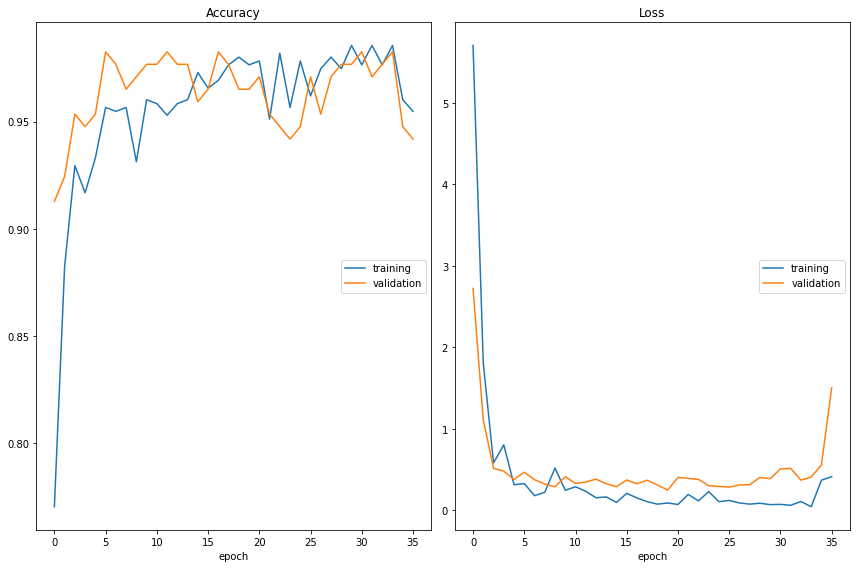

Accuracy
	training         	 (min:    0.770, max:    0.986, cur:    0.955)
	validation       	 (min:    0.913, max:    0.983, cur:    0.942)
Loss
	training         	 (min:    0.043, max:    5.704, cur:    0.411)
	validation       	 (min:    0.247, max:    2.722, cur:    1.501)
Epoch 00036: early stopping


In [ ]:
history_inceptionV4_1=inceptionV4_1.fit(rotation_train,batch_size=20, epochs=1000, verbose=2,validation_data=aug_validation,
                          callbacks=[History(),
                                     ModelCheckpoint('/content/drive/MyDrive/Formation_Machine_Learning/P6/transfer_learning/Inception_v4/5_breeds/fine_tuning',
                                                     monitor='val_acc', save_best_only=True, verbose=1),
               EarlyStopping(monitor='val_acc', patience=30, restore_best_weights=True, verbose=1),plot_tun1
              ]
    )

In [ ]:
aug_test.reset()

In [ ]:
inceptionV4_1=tf.keras.models.load_model('/content/drive/MyDrive/Formation_Machine_Learning/P6/transfer_learning/Inception_v4/5_breeds/fine_tuning')

In [ ]:
inceptionV4_1.evaluate(aug_test)

7/7 [==============================] - 4s 88ms/step - loss: 0.4319 - acc: 0.9449


[0.43189162015914917, 0.9448819160461426]

### 2 convoltional layers trainable

In [ ]:
inceptionV4_2=create_model(n_classes=classes, tuning_layers=5)

In [ ]:
inceptionV4_2.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_resnet_v2 (Functio (None, 5, 5, 1536)        54336736  
_________________________________________________________________
flatten_3 (Flatten)          (None, 38400)             0         
_________________________________________________________________
dense_6 (Dense)              (None, 512)               19661312  
_________________________________________________________________
dropout_3 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_7 (Dense)              (None, 5)                 2565      
Total params: 74,000,613
Trainable params: 23,794,213
Non-trainable params: 50,206,400
_________________________________________________________________


In [ ]:
plot_tun2=PlotLossesCallback()

In [ ]:
rotation_train.reset()
aug_validation.reset()

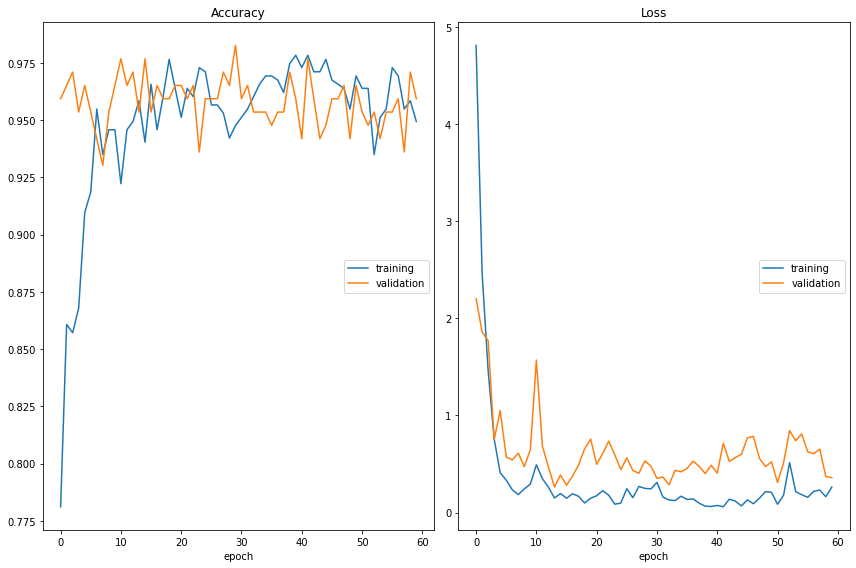

Accuracy
	training         	 (min:    0.781, max:    0.978, cur:    0.949)
	validation       	 (min:    0.930, max:    0.983, cur:    0.959)
Loss
	training         	 (min:    0.060, max:    4.814, cur:    0.262)
	validation       	 (min:    0.262, max:    2.204, cur:    0.359)
Epoch 00060: early stopping


In [ ]:
history_inceptionV4_2=inceptionV4_2.fit(rotation_train,batch_size=20, epochs=1000, verbose=2,validation_data=aug_validation,
                          callbacks=[History(),
                                     ModelCheckpoint('/content/drive/MyDrive/Formation_Machine_Learning/P6/transfer_learning/Inception_v4/5_breeds/fine_tuning2',
                                                     monitor='val_acc', save_best_only=True, verbose=1),
               EarlyStopping(monitor='val_acc', patience=30, restore_best_weights=True, verbose=1),plot_tun2
              ]
    )

In [ ]:
aug_test.reset()

In [ ]:
inceptionV4_2=tf.keras.models.load_model('/content/drive/MyDrive/Formation_Machine_Learning/P6/transfer_learning/Inception_v4/5_breeds/fine_tuning2')

In [ ]:
inceptionV4_2.evaluate(aug_test)

7/7 [==============================] - 4s 86ms/step - loss: 0.4855 - acc: 0.9606


[0.4854833781719208, 0.960629940032959]

### Comparing models

In [ ]:
def plot_heatmap(true_labels,pred_labels, class_names, ax, title):
    g=sns.heatmap(
        confusion_matrix(true_labels, pred_labels), 
        annot=True, 
        square=True, 
        xticklabels=class_names, 
        yticklabels=class_names,
        fmt='d', 
        cmap='coolwarm',
        cbar=False,
        ax=ax
    )
    ax.set_title(title, fontsize=16)
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right")
    ax.set_ylabel('True Label', fontsize=12)
    ax.set_xlabel('Predicted Label', fontsize=12)

    return g



In [ ]:
scratch_cnn=tf.keras.models.load_model('/content/drive/MyDrive/Formation_Machine_Learning/P6/5_breeds/rotation_data_5_breeds')

In [ ]:
aug_test.reset()

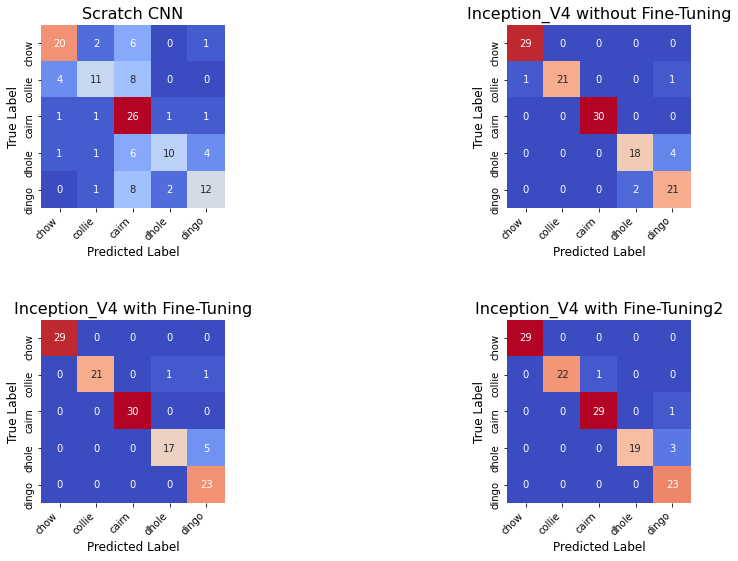

In [ ]:
classes=aug_test.class_indices.keys()
fig, axes = plt.subplots(
                     ncols=2,
                     nrows=2,
                     figsize=(15, 6))

ax1, ax2, ax3, ax4 = axes.flatten()

plot_heatmap(aug_test.classes, np.argmax(scratch_cnn.predict(aug_test), axis=1), classes, ax1, title="Scratch CNN")  
aug_test.reset()  
plot_heatmap(aug_test.classes, np.argmax(inceptionV4_0.predict(aug_test), axis=1), classes, ax2, title="Inception_V4 without Fine-Tuning")  
aug_test.reset()  
plot_heatmap(aug_test.classes, np.argmax(inceptionV4_1.predict(aug_test), axis=1), classes, ax3, title="Inception_V4 with Fine-Tuning")
aug_test.reset()
plot_heatmap(aug_test.classes, np.argmax(inceptionV4_2.predict(aug_test), axis=1), classes, ax4, title="Inception_V4 with Fine-Tuning2")  
aug_test.reset()   

fig.tight_layout()
fig.subplots_adjust(top=1.25)
plt.show()

# 20 Breeds

In [ ]:
breeds=['basset', 'borzoi', 'Walker_hound', 'bluetick', 'beagle', 'black and tan_coonhound', 'English_foxhound', 'Irish_wolfhound', 'redbone', 'bloodhound', 'Italian_greyhound',
 'whippet', 'Scottish_deerhound', 'Weimaraner', 'Bedlington_terrier', 'American_Staffordshire_terrier', 'Saluki', 'Staffordshire_bullterrier', 'Norwegian_elkhound', 'Ibizan_hound',]

## Setting the data

In [ ]:
rotation_gen=ImageDataGenerator(rotation_range=90,fill_mode='nearest',rescale=1/255)
rotation_train=rotation_gen.flow_from_directory(training_path, target_size=(224, 224),classes=breeds,
                              class_mode='categorical', batch_size=20)

Found 2314 images belonging to 20 classes.


In [ ]:
validation_gen=ImageDataGenerator(rescale=1/255)
aug_validation=validation_gen.flow_from_directory(validation_path,target_size=(224, 224),classes=breeds,
                              class_mode='categorical', batch_size=20, shuffle=False)

Found 712 images belonging to 20 classes.


In [ ]:
test_gen=ImageDataGenerator(rescale=1/255)
aug_test=validation_gen.flow_from_directory(test_path,target_size=(224, 224),classes=breeds,
                              class_mode='categorical', batch_size=20, shuffle=False)

Found 534 images belonging to 20 classes.


## No fine tuning

In [ ]:
inceptionV4_0_20breeds=create_model(n_classes=20,tuning_layers=0)

In [ ]:
plot_tun0_20=PlotLossesCallback()

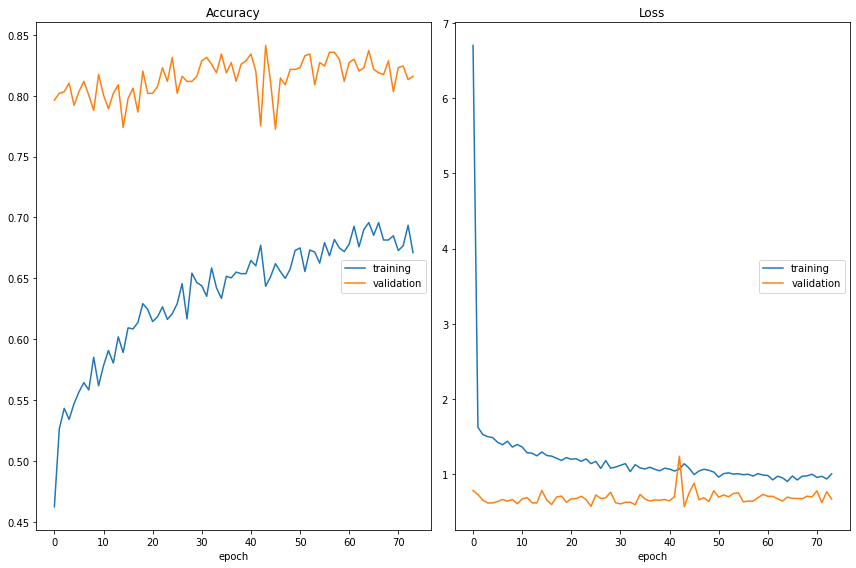

Accuracy
	training         	 (min:    0.462, max:    0.696, cur:    0.671)
	validation       	 (min:    0.772, max:    0.841, cur:    0.816)
Loss
	training         	 (min:    0.906, max:    6.698, cur:    1.007)
	validation       	 (min:    0.570, max:    1.240, cur:    0.671)
Epoch 00074: early stopping


In [ ]:
history_inceptionV4_20breeds=inceptionV4_0_20breeds.fit(rotation_train,batch_size=20, epochs=1000, verbose=1,validation_data=aug_validation,
                          callbacks=[History(),
                                     ModelCheckpoint('/content/drive/MyDrive/Formation_Machine_Learning/P6/transfer_learning/Inception_v4/20_breeds/no_fine_tuning',
                                                     monitor='val_acc', save_best_only=True, verbose=1),
               EarlyStopping(monitor='val_acc', patience=30, restore_best_weights=True, verbose=1),plot_tun0_20
              ]
    )

In [ ]:
aug_test.reset()

In [ ]:
inceptionV4_0_20breeds.evaluate(aug_test)

27/27 [==============================] - 154s 6s/step - loss: 0.6609 - acc: 0.7921


[0.6609488725662231, 0.7921348214149475]

## Fine tuning

In [ ]:
inceptionV4_1_20breeds=create_model(n_classes=20,tuning_layers=3)

In [ ]:
plot_tun1_20=PlotLossesCallback()

In [ ]:
rotation_train.reset()
aug_validation.reset()

In [ ]:
history_inceptionV4_1_20breeds=inceptionV4_1_20breeds.fit(rotation_train,batch_size=20, epochs=1000, verbose=1,validation_data=aug_validation,
                          callbacks=[History(),
                                     ModelCheckpoint('/content/drive/MyDrive/Formation_Machine_Learning/P6/transfer_learning/Inception_v4/20_breeds/fine_tuning',
                                                     monitor='val_acc', save_best_only=True, verbose=1),
               EarlyStopping(monitor='val_acc', patience=30, restore_best_weights=True, verbose=1),plot_tun1_20
              ]
    )

In [ ]:
aug_test.reset()

In [ ]:
inceptionV4_1_20breeds.evaluate(aug_test)

## Fine tuning: 2 convolutional layers

In [ ]:
inceptionV4_2_20breeds=create_model(n_classes=20,tuning_layers=5)

In [ ]:
plot_tun2_20=PlotLossesCallback()

In [ ]:
rotation_train.reset()
aug_validation.reset()

In [ ]:
history_inceptionV4_2_20breeds=inceptionV4_2_20breeds.fit(rotation_train,batch_size=20, epochs=1000, verbose=1,validation_data=aug_validation,
                          callbacks=[History(),
                                     ModelCheckpoint('/content/drive/MyDrive/Formation_Machine_Learning/P6/transfer_learning/Inception_v4/20_breeds/fine_tuning2',
                                                     monitor='val_acc', save_best_only=True, verbose=1),
               EarlyStopping(monitor='val_acc', patience=30, restore_best_weights=True, verbose=1),plot_tun2_20
              ]
    )

In [ ]:
aug_test.reset()

In [ ]:
inceptionV4_2_20breeds.evaluate(aug_test)

# 120 Breeds

## Setting the data

In [9]:
rotation_gen=ImageDataGenerator(rotation_range=90,fill_mode='nearest',rescale=1/255)
rotation_train=rotation_gen.flow_from_directory(training_path, target_size=(224, 224),classes=os.listdir(training_path),
                              class_mode='categorical', batch_size=20)

Found 13297 images belonging to 119 classes.
time: 19.9 s (started: 2021-06-28 23:25:58 +00:00)


In [10]:
validation_gen=ImageDataGenerator(rescale=1/255)
aug_validation=validation_gen.flow_from_directory(validation_path,target_size=(224, 224),classes=os.listdir(training_path),
                              class_mode='categorical', batch_size=20, shuffle=False)

Found 4055 images belonging to 119 classes.
time: 11.8 s (started: 2021-06-28 23:26:18 +00:00)


In [11]:
test_gen=ImageDataGenerator(rescale=1/255)
aug_test=validation_gen.flow_from_directory(test_path,target_size=(224, 224),classes=os.listdir(training_path),
                              class_mode='categorical', batch_size=20, shuffle=False)

Found 3037 images belonging to 119 classes.
time: 10.6 s (started: 2021-06-28 23:26:30 +00:00)


## No Fine tuning

In [ ]:
inceptionV4_0_120breeds=create_model(n_classes=119,tuning_layers=0)

In [ ]:
plot_tun0_120=PlotLossesCallback()

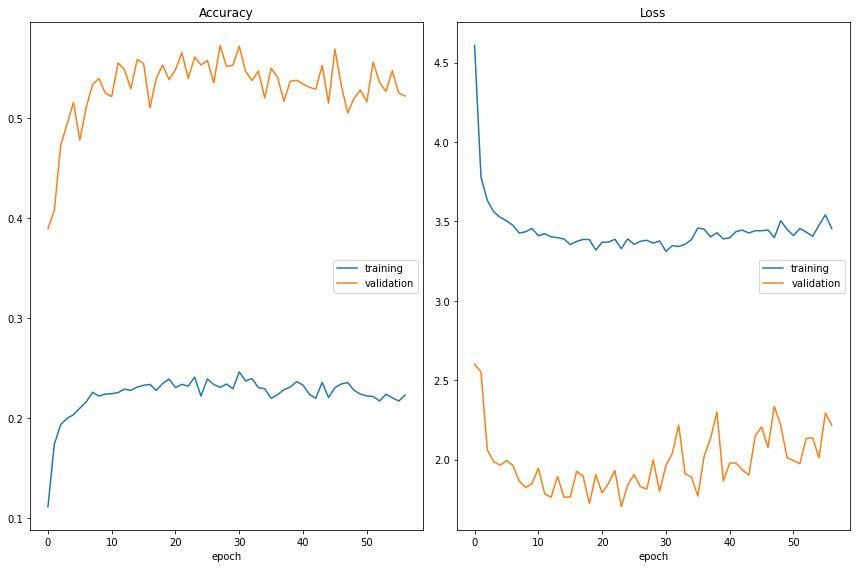

Accuracy
	training         	 (min:    0.111, max:    0.246, cur:    0.223)
	validation       	 (min:    0.389, max:    0.572, cur:    0.522)
Loss
	training         	 (min:    3.312, max:    4.608, cur:    3.455)
	validation       	 (min:    1.703, max:    2.601, cur:    2.218)
Epoch 58/1000
512/665 [======================>.......] - ETA: 38s - loss: 3.4550 - acc: 0.2219

In [ ]:
history_inceptionV4_120breeds=inceptionV4_0_120breeds.fit(rotation_train,batch_size=20, epochs=1000, verbose=1,validation_data=aug_validation,
                          callbacks=[History(),
                                     ModelCheckpoint('/content/drive/MyDrive/Formation_Machine_Learning/P6/transfer_learning/Inception_v4/120_breeds/no_fine_tuning',
                                                     monitor='val_acc', save_best_only=True, verbose=1),
               EarlyStopping(monitor='val_acc', patience=30, restore_best_weights=True, verbose=1),plot_tun0_120
              ]
    )

In [ ]:
inceptionV4_0_120breeds=tf.keras.models.load_model('/content/drive/MyDrive/Formation_Machine_Learning/P6/transfer_learning/Inception_v4/120_breeds/no_fine_tuning')

In [ ]:
aug_test.reset()

In [ ]:
inceptionV4_0_120breeds.evaluate(aug_test)

152/152 [==============================] - 1814s 12s/step - loss: 2.0057 - acc: 0.5568


[2.005690574645996, 0.5567994713783264]

## fine tuning

In [ ]:
inceptionV4_1_120breeds=create_model(n_classes=119,tuning_layers=3)

219070464/219055592 [==============================] - 1s 0us/step
time: 9.67 s (started: 2021-06-28 12:42:49 +00:00)


In [ ]:
plot_tun1_120=PlotLossesCallback()

time: 1.49 ms (started: 2021-06-28 12:42:59 +00:00)


In [ ]:
rotation_train.reset()

time: 717 µs (started: 2021-06-28 12:42:59 +00:00)


In [ ]:
aug_validation.reset()

time: 908 µs (started: 2021-06-28 12:43:05 +00:00)


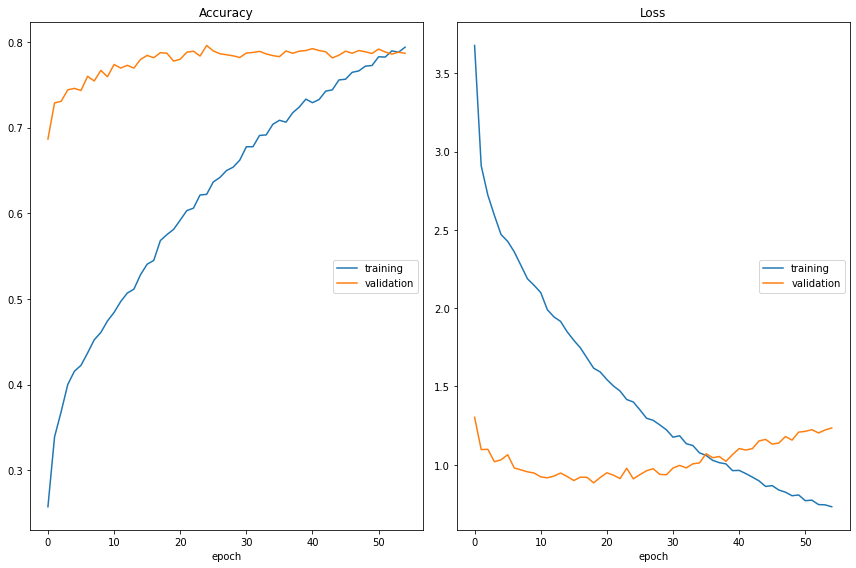

Accuracy
	training         	 (min:    0.258, max:    0.794, cur:    0.794)
	validation       	 (min:    0.687, max:    0.796, cur:    0.787)
Loss
	training         	 (min:    0.732, max:    3.678, cur:    0.732)
	validation       	 (min:    0.885, max:    1.303, cur:    1.235)
Epoch 00055: early stopping
time: 5h 52min (started: 2021-06-28 12:43:10 +00:00)


In [ ]:
history_inceptionV4_1_120breeds=inceptionV4_1_120breeds.fit(rotation_train,batch_size=20, epochs=1000, verbose=1,validation_data=aug_validation,
                          callbacks=[History(),
                                     ModelCheckpoint('/content/drive/MyDrive/Formation_Machine_Learning/P6/transfer_learning/Inception_v4/120_breeds/fine_tuning',
                                                     monitor='val_acc', save_best_only=True, verbose=1),
               EarlyStopping(monitor='val_acc', patience=30, restore_best_weights=True, verbose=1),plot_tun1_120
              ]
    )

In [ ]:
inceptionV4_1_120breeds= load_model('/content/drive/MyDrive/Formation_Machine_Learning/P6/transfer_learning/Inception_v4/120_breeds/fine_tuning')

In [ ]:
aug_test.reset()

In [ ]:
inceptionV4_1_120breeds.evaluate(aug_test)

152/152 [==============================] - 1462s 10s/step - loss: 1.0606 - acc: 0.7830


[1.0606476068496704, 0.7830095291137695]

## fine tuning2

In [12]:
inceptionV4_2_120breeds=create_model(n_classes=119,tuning_layers=5)

219070464/219055592 [==============================] - 3s 0us/step
time: 11.5 s (started: 2021-06-28 23:26:41 +00:00)


In [13]:
plot_tun2_120=PlotLossesCallback()

time: 1.6 ms (started: 2021-06-28 23:26:52 +00:00)


In [ ]:
rotation_train.reset()

time: 896 µs (started: 2021-06-28 18:35:16 +00:00)


In [ ]:
aug_validation.reset()

time: 675 µs (started: 2021-06-28 18:35:16 +00:00)


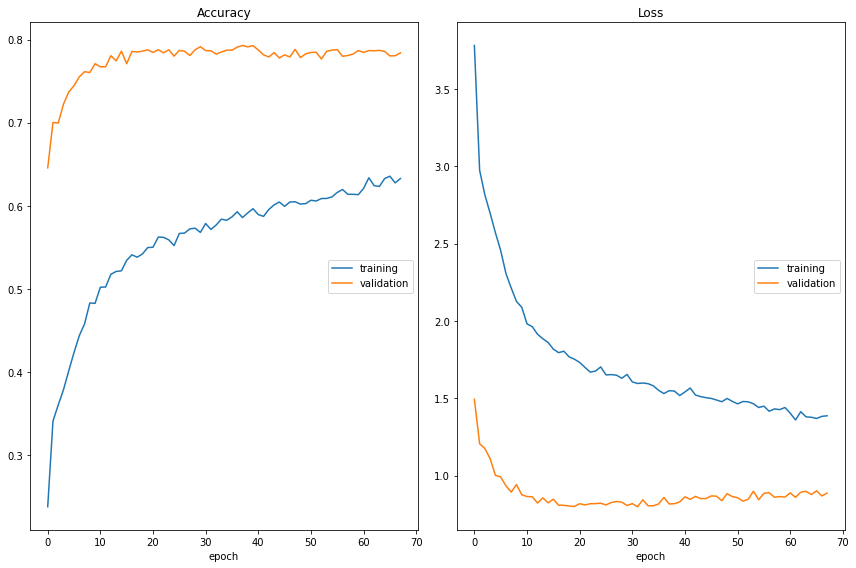

Accuracy
	training         	 (min:    0.238, max:    0.636, cur:    0.633)
	validation       	 (min:    0.646, max:    0.793, cur:    0.784)
Loss
	training         	 (min:    1.360, max:    3.782, cur:    1.387)
	validation       	 (min:    0.799, max:    1.493, cur:    0.887)
Epoch 00068: early stopping
time: 5h 59min 7s (started: 2021-06-28 23:26:52 +00:00)


In [14]:
history_inceptionV4_2_120breeds=inceptionV4_2_120breeds.fit(rotation_train,batch_size=20, epochs=1000, verbose=1,validation_data=aug_validation,
                          callbacks=[History(),
                                     ModelCheckpoint('/content/drive/MyDrive/Formation_Machine_Learning/P6/transfer_learning/Inception_v4/120_breeds/fine_tuning2',
                                                     monitor='val_acc', save_best_only=True, verbose=1),
               EarlyStopping(monitor='val_acc', patience=30, restore_best_weights=True, verbose=1),plot_tun2_120
              ]
    )

In [ ]:
aug_test.reset()

In [ ]:
inceptionV4_2_120breeds.evaluate(aug_test)

152/152 [==============================] - 9s 62ms/step - loss: 0.9013 - acc: 0.7791


[0.901338517665863, 0.7790582776069641]